# Create initial condition fields for Mn

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
from salishsea_tools import (
    nc_tools,
    viz_tools,
)
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import stations
import glob

%matplotlib inline

/ocean/brogalla/GEOTRACES/analysis-birgit/cmocean-master/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


### Load Marco Van Hulten's model output:

In [2]:
folder = '/ocean/brogalla/GEOTRACES/data/van_hulten/'
file = 'Fmang-16B05-LD40_Bio_1y_ptrc_T_P80.nc' #Fmang-16B05-LD40_Bio_1y_diad_T_P80.nc 

In [3]:
a = nc.Dataset(folder+file)

mn_dis = a.variables['dMn'] # time, deptht, y, x
mn_oxi = a.variables['oMn']
depths = a.variables['deptht']
time = a.variables['time']
lats = a.variables['nav_lat']
lons = a.variables['nav_lon']

In [5]:
time.shape

(1,)

In [6]:
time

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    bounds: time_bnds
    units: seconds since 1900-01-01 00:00:00
    calendar: 365_day
unlimited dimensions: time
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [4]:
mask = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12_mask.nc')
tmask = mask.variables['tmask']
tmask = np.array(tmask[0,0,:,:])
mlons = mask.variables['nav_lon']
mlats = mask.variables['nav_lat']
mlons = np.array(mlons)
mlats = np.array(mlats)
cond = (tmask > 0.1) 
Z_masked = np.ma.masked_where(cond, tmask) 

In [5]:
def plot_variable(variable, lons, lats, depth_level=0):
    # plot background map of land:
    fig,ax = plt.subplots(figsize=(10,10))
    proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
    proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=3)
    #proj.fillcontinents(color=[0.75, 0.75, 0.75], lake_color=None, zorder=2) 
#     proj.drawlsmask(land_color='0.8', ocean_color='w',\
#                     lsmask=tmask, lsmask_lons=lons_ref, lsmask_lats=lats_ref, lakes=False)
    proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
    proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

    lats = np.array(lats)
    lons = np.array(lons)
    x, y = proj(lons, lats)
    
    var_name = variable.name
    variable = np.array(variable)
    x1 = x[:,:]
    y1 = y[:,:]
    if depth_level == -1:
        z1 = variable[0][:,:]
    else:
        z1 = variable[0][depth_level,:,:]
        
    x2, y2 = proj(mlons, mlats)
    z2 = Z_masked
    
    cmap1 =cmocean.cm.gray_r
    
    CS1 = proj.pcolor(x1, y1, z1, cmap=cmocean.cm.deep)
    proj.pcolor(x2,y2,z2, cmap=cmap1)
    cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.7]) 
    CBar = plt.colorbar(CS1, ax=ax, cax=cbaxes) 
    a = CBar.set_label(var_name + ' [kmol / m3]', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    fig.savefig(var_name +'_ini.png',bbox_inches='tight')
    return

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


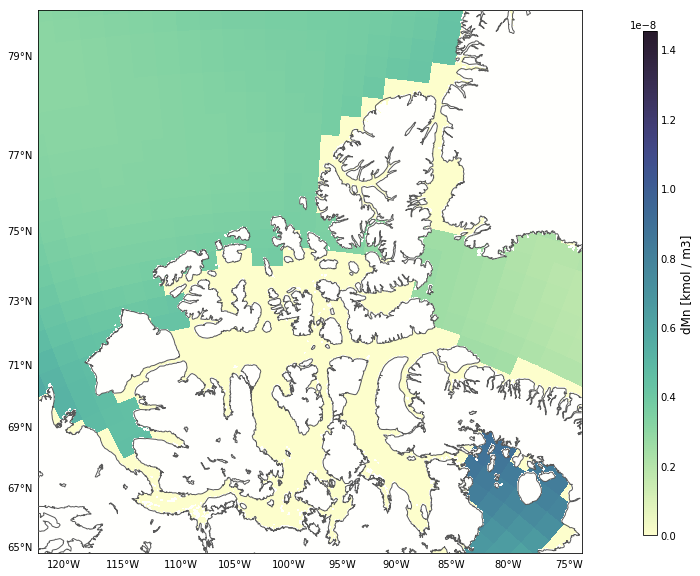

In [6]:
plot_variable(mn_dis, lons, lats)

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


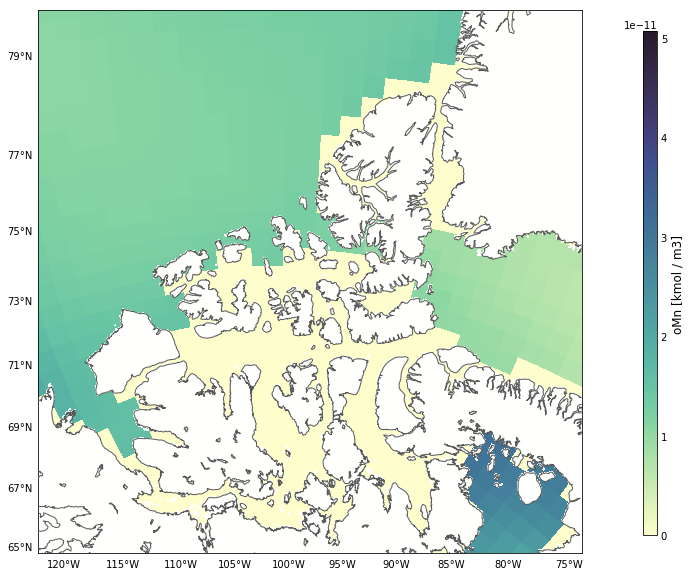

In [7]:
plot_variable(mn_oxi, lons, lats)

### Load ANHA12 fields to interpolate to:

In [8]:
mesh = '/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc'
m = nc.Dataset(mesh)

In [9]:
mdepth = m.variables['deptht']
mlons = m.variables['nav_lon']
mlats = m.variables['nav_lat']

In [10]:
mdepth = np.array(mdepth)
mlons = np.array(mlons)
mlats = np.array(mlats)

### Interpolate from outer boundaries:

First interpolate with depth: depths --> mdepth

In [11]:
print('Original size: ' + str(depths.shape))
print('New size: ' + str(mdepth.shape))

Original size: (31,)
New size: (50,)


In [12]:
mn_oxi = np.array(mn_oxi)
mn_dis = np.array(mn_dis)

In [13]:
mn_dis.shape

(1, 31, 149, 182)

In [14]:
search_dis = mn_dis[0,:,:,:]
for i in range(0,31):
    for j in range(0,149):
        for k in range(0,182):
            if search_dis[i,j,k] > 1.0e1:
                print(i,j,k)

30 93 34


In [15]:
mn_oxi[mn_oxi==0] = 1.0e-11
mn_dis[mn_dis==0] = 0.3e-8
mn_dis[0,30,93,34] = 0.3e-8

In [16]:
def interp_depths(var, mdepth,fill):
    # constant extrapolation for values outside of the range
    from scipy import interpolate
    
    interp_var = np.empty((50, 149, 182))
    x = depths
    
    for i in range(0,149):
        for j in range(0,182):
            # interpolate over depths        
            y = var[0,:,i,j]
            f = interpolate.interp1d(x, y, fill_value = fill)
            interp_var[:,i,j] = f(mdepth)
    return interp_var

In [17]:
i_mn_oxi = interp_depths(mn_oxi, mdepth, fill='extrapolate')
i_mn_dis = interp_depths(mn_dis, mdepth, fill='extrapolate')
i_mn_oxi = np.array(i_mn_oxi)
i_mn_dis = np.array(i_mn_dis)

In [18]:
i_mn_oxi[i_mn_oxi<0] = 1.0e-11
i_mn_dis[i_mn_dis<0] = 0.3e-8

Then spatially: lons --> mlons, lats --> mlats

In [19]:
lons = np.array(lons)
lats = np.array(lats)
mlons = np.array(mlons)
mlats = np.array(mlats)

In [20]:
print(np.amin(i_mn_dis))
print(np.amax(i_mn_dis))
print(np.average(i_mn_dis))

3.30176055767e-12
5.1750308927e-08
1.72515815936e-09


In [21]:
print(np.amin(i_mn_oxi))
print(np.amax(i_mn_oxi))
print(np.average(i_mn_oxi))

1.1458856528e-14
4.61645477401e-09
1.69139115944e-11


In [22]:
print(i_mn_oxi.shape)

(50, 149, 182)


In [23]:
# i_lons = lons.flatten()
# i_lats = lats.flatten()
# i_var = i_mn_oxi[0,:,:].flatten()

In [24]:
# ir_mn_oxi = np.array([i[~np.isnan(i)] for i in i_mn_oxi])
# ir_mn_dis = np.array([i[~np.isnan(i)] for i in i_mn_dis])
# ir_lons = np.array(i_lons[~np.isnan(i_var)])
# ir_lats = np.array(i_lats[~np.isnan(i_var)])

In [25]:
def interp_np(nav_lon, nav_lat, var_in, lon_ANHA12, lat_ANHA12):
    ''' Interpolate Mn model output from Marco to ANHA12 grid.
        The function is based on the bilinear interpolation in scipy, griddata 
        =======================================================================
            nav_lon, nav_lat        : Mn model lons/lats
            lon_ANHA12, lat_ANHA12  : ANHA12 defined lons/lats
            var_in                  : 2-D Mn model variable
    '''
    from scipy.interpolate import griddata

    LatLonPair = (nav_lon.flatten(), nav_lat.flatten())
    var_out = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='linear')
    # Take nearest neighbour interpolation to fill nans
    var_fill = griddata(LatLonPair, var_in.flatten(), (lon_ANHA12, lat_ANHA12), method='nearest')
    var_out[np.isnan(var_out)] = var_fill[np.isnan(var_out)]
    return var_out

In [26]:
ini_mn_oxi = np.empty((50, 2400, 1632))
ini_mn_dis = np.empty((50, 2400, 1632))

for i in range(0,50):
    ini_mn_oxi[i,:,:] = interp_np(lons, lats, i_mn_oxi[i,:,:], mlons, mlats)
    ini_mn_dis[i,:,:] = interp_np(lons, lats, i_mn_dis[i,:,:], mlons, mlats)

In [27]:
i_mn_oxi[0,:,:].shape

(149, 182)

In [28]:
# Check whether any of the values are NaN:
print(np.count_nonzero(np.isnan(ini_mn_oxi)))
print(np.count_nonzero(np.isnan(ini_mn_dis)))

0
0


In [29]:
def plot_ini(variable, lons, lats, label, depth_level=0):
    # plot background map of land:
    fig,ax = plt.subplots(figsize=(10,10))
    proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
    proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=3)
    #proj.fillcontinents(color=[0.75, 0.75, 0.75], lake_color=None, zorder=2) 
    proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
    proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

    lats = np.array(lats)
    lons = np.array(lons)
    x, y = proj(lons, lats)
    
    variable = np.array(variable)
    x1 = x[:,:]
    y1 = y[:,:]
    z1 = variable[depth_level,:,:]
    
    p2_lon = mlons[172+910,585+200]
    p2_lat = mlats[172+910,585+200]
    
    x2, y2 = proj(p2_lon, p2_lat)
    
    proj.scatter(x2, y2, marker='*',s=130,zorder=3, c='r')

    CS1 = proj.pcolor(x1, y1, z1, cmap=cmocean.cm.deep)
    
    x2, y2 = proj(mlons, mlats)
    z2 = Z_masked
    cmap1 =cmocean.cm.gray_r
    proj.pcolor(x2,y2,z2, cmap=cmap1)
    
    cbaxes = fig.add_axes([0.975, 0.15, 0.02, 0.7]) 
    CBar = plt.colorbar(CS1, ax=ax, cax=cbaxes) 
    a = CBar.set_label(label+' [kmol / m3]', fontsize=12)
    CBar.ax.tick_params(axis='y', length=0)
    
    fig.savefig(label+'_ini_field.png', bbox_inches='tight')
    return

#### linear interpolation w. constant values filled in:

In [30]:
print(np.amax(ini_mn_oxi))
print(np.amax(ini_mn_dis))

5.4434266276e-10
1.46095476739e-08


/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


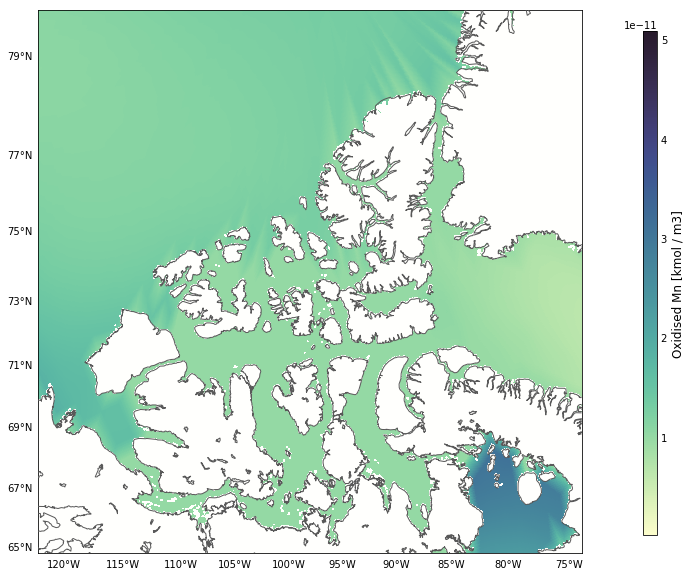

In [31]:
plot_ini(ini_mn_oxi, mlons, mlats, 'Oxidised Mn')

In [32]:
ini_mn_oxi.shape

(50, 2400, 1632)

In [33]:
print(mlons[:,:])
print(mlats[1100,600])

[[ -98.25        -98.16666412  -98.08333588 ...,   37.5          37.58333206
    37.66666794]
 [ -98.25        -98.16666412  -98.08333588 ...,   37.5          37.58333206
    37.66666794]
 [ -98.25        -98.16666412  -98.08333588 ...,   37.5          37.58333206
    37.66666794]
 ..., 
 [-114.35292053 -114.42304993 -114.49317932 ...,  103.16661072
   103.09623718  103.02588654]
 [-114.35930634 -114.42949677 -114.49968719 ...,  103.19085693
   103.12041473  103.04999542]
 [-114.36566925 -114.43592072 -114.50617218 ...,  103.21501923
   103.14450836  103.07402802]]
58.1131


(50, 0)

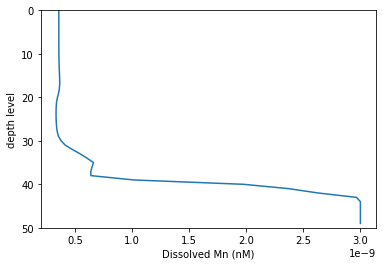

In [34]:
plt.figure()
plt.gca().invert_yaxis()
depth = np.arange(0,50)
x=172+910
y=585+200
plt.plot(ini_mn_dis[:,x,y],depth)
plt.ylabel('depth level')
plt.xlabel('Dissolved Mn (nM)')
plt.ylim([50, 0])

In [ ]:
plt.figure()
plt.gca().invert_yaxis()
depth = np.arange(0,50)
x=172+910
y=585+200
plt.plot(ini_mn_oxi[:,x,y],depth)
plt.ylabel('depth level')
plt.xlabel('Oxidised Mn (nM)')
plt.ylim([50, 0])

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


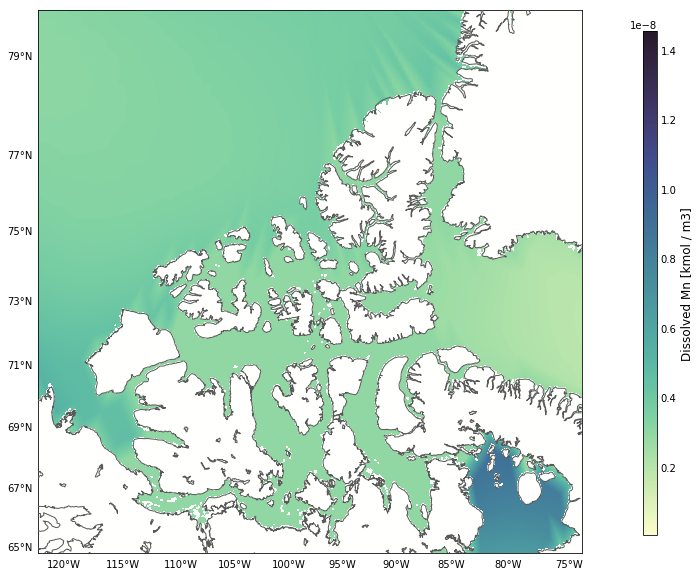

In [84]:
plot_ini(ini_mn_dis, mlons, mlats, 'Dissolved Mn')

### Load observations:

Load observations

In [85]:
CAA1 = stations.CAA1()
CAA2 = stations.CAA2()
CAA3 = stations.CAA3()
CAA4 = stations.CAA4()
CAA5 = stations.CAA5()
CAA6 = stations.CAA6()
CAA7 = stations.CAA7()
CAA8 = stations.CAA8()
CAA9 = stations.CAA9()
CB1 = stations.CB1()
CB2 = stations.CB2()
CB3 = stations.CB3()
CB4 = stations.CB4()
BB1 = stations.BB1()
BB2 = stations.BB2()
BB3 = stations.BB3()
K1 = stations.K1()
LS2 = stations.LS2()

In [86]:
names = ['CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
         'CB1', 'CB2', 'CB3', 'CB4', 'BB1', 'BB2', 'BB3', 'K1', 'LS2']
lons_obs = [CAA1.lon, CAA2.lon, CAA3.lon, CAA4.lon, CAA5.lon, CAA6.lon, CAA7.lon, CAA8.lon, CAA9.lon, \
        CB1.lon, CB2.lon, CB3.lon, CB4.lon, BB1.lon, BB2.lon, BB3.lon, K1.lon, LS2.lon]
lats_obs = [CAA1.lat, CAA2.lat, CAA3.lat, CAA4.lat, CAA5.lat, CAA6.lat, CAA7.lat, CAA8.lat, CAA9.lat, \
        CB1.lat, CB2.lat, CB3.lat, CB4.lat, BB1.lat, BB2.lat, BB3.lat, K1.lat, LS2.lat]

In [87]:
dMn_obs = np.array([CAA1.dMn, CAA2.dMn, CAA3.dMn, CAA4.dMn, CAA5.dMn, CAA6.dMn, CAA7.dMn, CAA8.dMn, CAA9.dMn, \
        CB1.dMn, CB2.dMn, CB3.dMn, CB4.dMn, BB1.dMn, BB2.dMn, BB3.dMn, K1.dMn, LS2.dMn])
ddepth = [CAA1.depth, CAA2.depth, CAA3.depth, CAA4.depth, CAA5.depth, CAA6.depth, CAA7.depth, CAA8.depth, \
          CAA9.depth, CB1.depth, CB2.depth, CB3.depth, CB4.depth, BB1.depth, BB2.depth, BB3.depth, \
          K1.depth, LS2.depth]
pMn_obs = np.array([CAA1.pMn, CAA2.pMn, CAA3.pMn, CAA4.pMn, CAA5.pMn, CAA6.pMn, CAA7.pMn, CAA8.pMn, CAA9.pMn, \
        CB1.pMn, CB2.pMn, CB3.pMn, CB4.pMn, BB1.pMn, BB2.pMn, BB3.pMn, K1.pMn, LS2.pMn])
pdepth = [CAA1.pdepth, CAA2.pdepth, CAA3.pdepth, CAA4.pdepth, CAA5.pdepth, CAA6.pdepth, CAA7.pdepth, CAA8.pdepth, \
          CAA9.pdepth, CB1.pdepth, CB2.pdepth, CB3.pdepth, CB4.pdepth, BB1.pdepth, BB2.pdepth, BB3.pdepth, \
          K1.pdepth, LS2.pdepth]

In [88]:
dMn_obs_s = np.empty(len(lons_obs))
for i in range(0,len(names)):
    dMn_obs_s[i] = dMn_obs[i][0]

In [89]:
pMn_obs_s = np.empty(len(lons_obs))
for i in range(0,len(names)):
    pMn_obs_s[i] = pMn_obs[i][0]

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


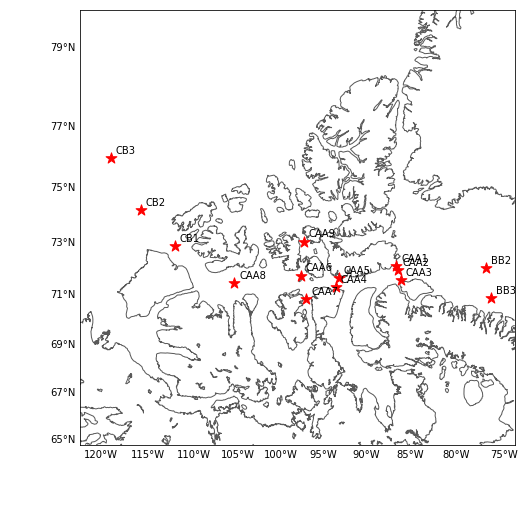

In [93]:
fig,ax = plt.subplots(figsize=(8,8))
proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1)
proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

x_obs, y_obs = proj(lons_obs, lats_obs)
 
proj.scatter(x_obs, y_obs, marker='*',s=130,zorder=3, c='r')

for i, (X, Y) in enumerate(zip(x_obs, y_obs), start=1):
    ax.annotate(names[i-1], (X,Y), xytext=(5, 5), textcoords='offset points')

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0,0.5,'Latitude')

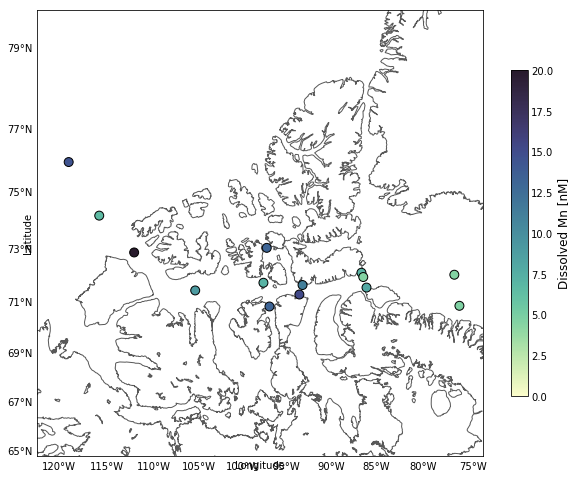

In [94]:
fig,ax = plt.subplots(figsize=(10,10))

proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1)
proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

x_obs, y_obs = proj(lons_obs, lats_obs)
CS = proj.scatter(x_obs, y_obs, c=dMn_obs_s,vmin=0,vmax=20, s=80, cmap=cmocean.cm.deep, edgecolors='k', zorder=3)

CBar = plt.colorbar(CS, shrink=0.6)
CBar.set_label('Dissolved Mn [nM]', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0,0.5,'Latitude')

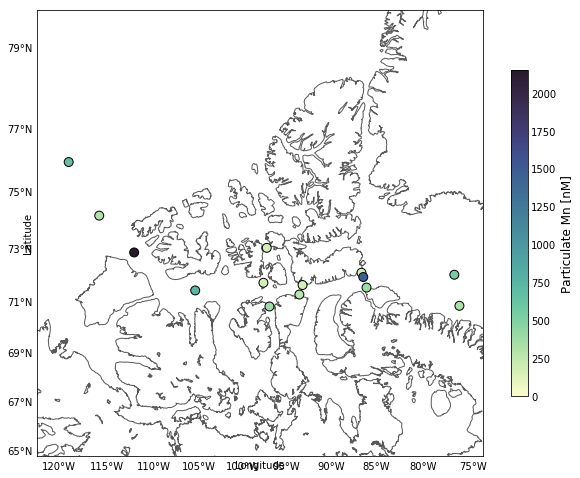

In [95]:
fig,ax = plt.subplots(figsize=(10,10))

proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1)

proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

x_obs, y_obs = proj(lons_obs, lats_obs)
CS = proj.scatter(x_obs, y_obs, c=pMn_obs_s,vmin=0,vmax=2150, s=80, \
                  cmap=cmocean.cm.deep, zorder=3, edgecolors='k')

CBar = plt.colorbar(CS, shrink=0.6)
CBar.set_label('Particulate Mn [nM]', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

### Compare interpolated field with observations:

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0,0.5,'Latitude')

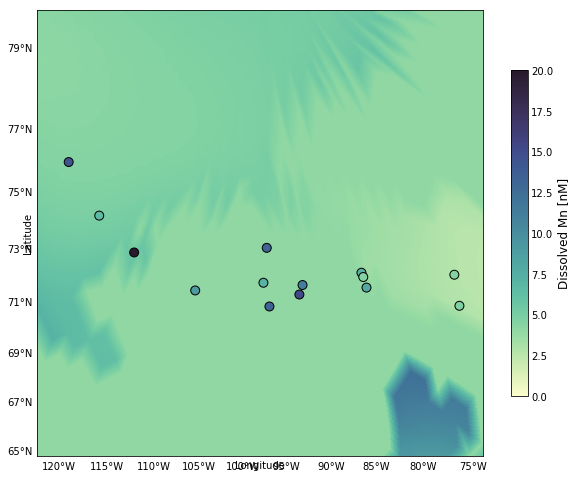

In [96]:
fig,ax = plt.subplots(figsize=(10,10))

proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1)
proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

x, y = proj(mlons, mlats)
z1 = ini_mn_dis[0,:,:]
CS1 = proj.pcolor(x, y, z1, cmap=cmocean.cm.deep, zorder=2)

x_obs, y_obs = proj(lons_obs, lats_obs)
CS = proj.scatter(x_obs, y_obs, c=dMn_obs_s,vmin=0,vmax=20, s=80, cmap=cmocean.cm.deep, edgecolors='k', zorder=3)

CBar = plt.colorbar(CS, shrink=0.6)
CBar.set_label('Dissolved Mn [nM]', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3342: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3381: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0,0.5,'Latitude')

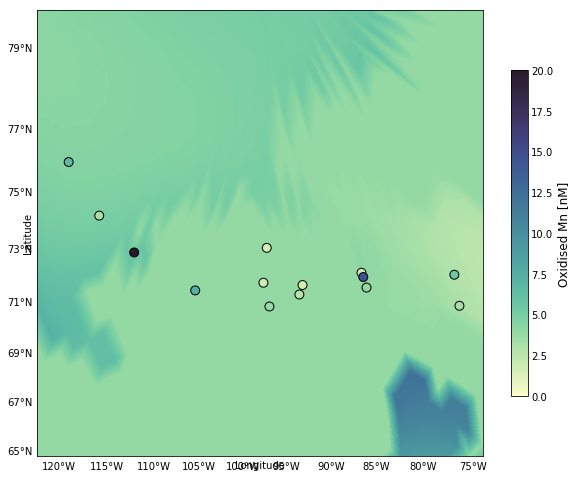

In [97]:
fig,ax = plt.subplots(figsize=(10,10))

proj=Basemap(projection='eqdc',lat_0 = 77, lon_0 = -98, resolution='i', width=2.25e6, height=2.25e6)
proj.drawcoastlines(linestyle='-', color=[0.35, 0.35, 0.35], linewidth=1, zorder=1)
proj.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
proj.drawmeridians(np.arange(int(-140),int(-30),5),labels=[0,0,0,1], linewidth=0.0)

x, y = proj(mlons, mlats)
z1 = ini_mn_oxi[0,:,:]
CS1 = proj.pcolor(x, y, z1, cmap=cmocean.cm.deep, zorder=2)

x_obs, y_obs = proj(lons_obs, lats_obs)
CS = proj.scatter(x_obs, y_obs, c=[i/100 for i in pMn_obs_s],\
                  vmin=0,vmax=20, s=80, cmap=cmocean.cm.deep, edgecolors='k', zorder=3)

CBar = plt.colorbar(CS, shrink=0.6)
CBar.set_label('Oxidised Mn [nM]', fontsize=12)
CBar.ax.tick_params(axis='y', length=0)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [35]:
print(np.average(ini_mn_oxi))
print(np.amax(ini_mn_oxi))
print(np.amin(ini_mn_oxi))
print(np.average(ini_mn_dis))
print(np.amax(ini_mn_dis))
print(np.amin(ini_mn_dis))

1.61056352467e-11
5.4434266276e-10
7.62266044461e-14
2.43230503694e-09
1.46095476739e-08
2.19095058336e-11


In [36]:
ini_mn_oxi.shape

(50, 2400, 1632)

### Write NetCDF IC file:

In [37]:
c = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12-EXH006_5d_gridT_y2002m01d05.nc','r')

# Load structure from sample dataset:
lat = c.variables['nav_lat']
lon = c.variables['nav_lon']
depths = c.variables['deptht']
time = c.variables['time_counter']
BX = c.dimensions['x']
BY = c.dimensions['y']
BT = c.dimensions['time_counter']
depth_out = depths

In [38]:
print(depths.shape)
print(lat.shape)
print(lon.shape)
print(BX)
print(BY)
omn_var_ini = np.array(ini_mn_oxi)
dmn_var_ini = np.array(ini_mn_dis)

(50,)
(2400, 1632)
(2400, 1632)
<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 1632

<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 2400



In [39]:
# Setup the new NetCDF file:
ncd = nc.Dataset('Mn_ini_20180716.nc', 'w', zlib=True)
nc_tools.init_dataset_attrs(
    ncd,
    title='Mn initial condition',
    notebook_name='IC',
    nc_filepath='./Mn_ini_20180709_constant.nc',
    comment='Initial field of tracer concentration')

ncd.createDimension('x',len(BX))
ncd.createDimension('y',len(BY))
ncd.createDimension('deptht',size=len(depth_out))
ncd.createDimension('time_counter',None)

file format: NETCDF4
Conventions: CF-1.6
title: Mn initial condition
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/ccar-modeling/analysis-birgit/src/tip/notebooks/ANHA12/IC/IC.ipynb
references: REQUIRED
history: [2018-07-16 13:16:00] Created netCDF4 zlib=True dataset.
comment: Initial field of tracer concentration


<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0

In [40]:
omn_var_ini.shape

(50, 2400, 1632)

In [41]:
# variables
dmn_var = ncd.createVariable('dMn', 'float64', ('time_counter','deptht','y','x'))
dmn_var.units = 'kmol/m3'
dmn_var.long_name = 'Dissolved Mn concentration'  
dmn_var.coordinates = 'nav_lon nav_lat deptht time_counter'
dmn_var[0,:,:,:] = dmn_var_ini

omn_var = ncd.createVariable('oMn', 'float64', ('time_counter','deptht','y','x'))
omn_var.units = 'kmol/m3'
omn_var.long_name = 'Oxidised Mn concentration'  
omn_var.coordinates = 'nav_lon nav_lat deptht time_counter'
omn_var[0,:,:,:] = omn_var_ini

In [42]:
print(dmn_var)
print(omn_var)

<class 'netCDF4._netCDF4.Variable'>
float64 dMn(time_counter, deptht, y, x)
    units: kmol/m3
    long_name: Dissolved Mn concentration
    coordinates: nav_lon nav_lat deptht time_counter
unlimited dimensions: time_counter
current shape = (1, 50, 2400, 1632)
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
float64 oMn(time_counter, deptht, y, x)
    units: kmol/m3
    long_name: Oxidised Mn concentration
    coordinates: nav_lon nav_lat deptht time_counter
unlimited dimensions: time_counter
current shape = (1, 50, 2400, 1632)
filling on, default _FillValue of 9.969209968386869e+36 used



In [43]:
nc_tools.check_dataset_attrs(ncd)
ncd.close()

Missing value for dataset attribute: references
